In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.1 MB/s eta 0:00:00


In [7]:
import os
import cv2
import random
import pathlib 
import pydicom
import numpy as np
import tensorflow as tf
from pydicom import dcmread
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

In [8]:
covid = []
normal = []
label1 = []
label0 = []
data = []
data0 = []
data1 = []
labels = []
c = 0
b = 0


In [9]:
# Using os.walk()
for root, dirs, files in os.walk(r"/content/drive/MyDrive/Data/covid19", topdown=True):
   for name in files:
      ct_scan = pydicom.dcmread(os.path.join(root,name))
      ct_s = ct_scan.pixel_array
      try:
          ct=cv2.resize(ct_s,(100,100)) / 255.0
          covid.append(ct)
          #label1.append(1)
      except:
          c+=1
          continue
print("Number of Covid images skipped = ",c)
      #ct_s = cv2.resize(ct_s,IMAGE_SIZE)
      #images.append(ct_s)      
covid = np.asarray(covid)
print(covid.shape)

Number of Covid images skipped =  0
(20149, 100, 100)


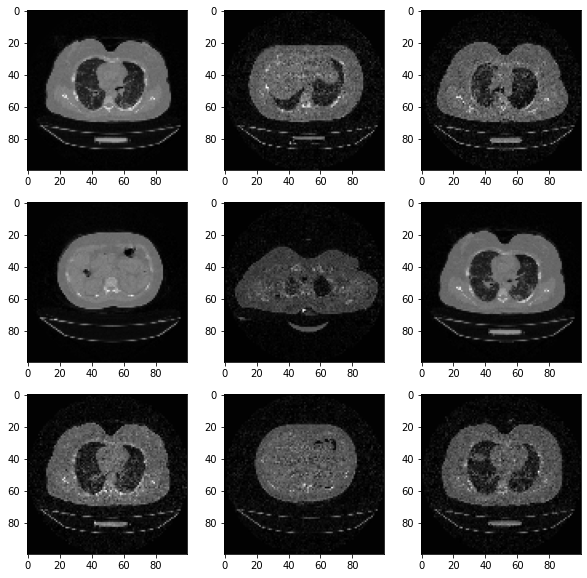

In [10]:
#printing images of covid patients

fig, axis = plt.subplots(3, 3, figsize = (10, 10))
slice_counter = 0
for i in range(3):
  for j in range(3):
    axis[i][j].imshow(covid[slice_counter], cmap = "gray")
    slice_counter += 1

In [11]:
covid1 = np.reshape(covid, (covid.shape[0],10000))
covid1 = np.append(covid1, np.ones((covid.shape[0],1)), axis = 1)
print(covid1.shape)

(20149, 10001)


In [12]:
covid1_train = covid1[0:int((covid1.shape[0]*0.7)),:]
covid1_test = covid1[covid1_train.shape[0]:covid1.shape[0],:]
covid1_cv = covid1_test[0:int((covid1_test.shape[0]*0.5)),:]
covid1_test = covid1_test[covid1_cv.shape[0]:covid1_test.shape[0],:]
print(covid1_train.shape)
print(covid1_cv.shape)
print(covid1_test.shape)

(14104, 10001)
(3022, 10001)
(3023, 10001)


In [13]:
for root, dirs, files in os.walk(r"/content/drive/MyDrive/Data/non-covid", topdown=True):
   for name in files:
      norm_scan = pydicom.dcmread(os.path.join(root,name))
      normal_scan = norm_scan.pixel_array
      try:
          norm=cv2.resize(normal_scan,(100,100)) / 255.0
          normal.append(norm)
          label0.append(0)
      except:
          b+=1
          continue
print("Number of non-covid images skipped= ",b) 

Number of non-covid images skipped=  0


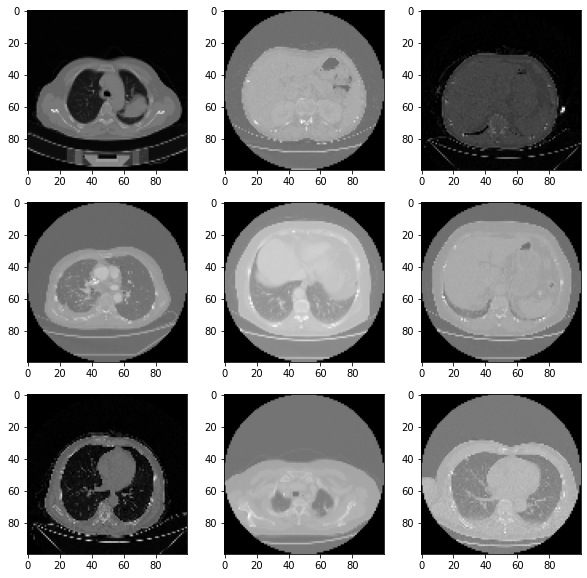

In [17]:
#print the normal CT-scan images

fig, axis = plt.subplots(3, 3, figsize = (10, 10))
slice_counter = 0
for i in range(3):
  for j in range(3):
    axis[i][j].imshow(normal[slice_counter], cmap = "gray")
    slice_counter += 1

In [18]:
normal = np.asarray(normal)
print(normal.shape)

(6976, 100, 100)


In [19]:
normal = np.reshape(normal, (normal.shape[0],10000))
normal = np.append(normal, np.zeros((normal.shape[0],1)), axis = 1)
print(normal.shape)

(6976, 10001)


In [20]:
normal_train = normal[0:int((normal.shape[0]*0.7)),:]
normal_test = normal[normal_train.shape[0]:normal.shape[0],:]
normal_cv = normal_test[0:int((normal_test.shape[0]*0.5)),:]
normal_test = normal_test[normal_cv.shape[0]:normal_test.shape[0],:]
print(normal_train.shape)
print(normal_cv.shape)
print(normal_test.shape)

(4883, 10001)
(1046, 10001)
(1047, 10001)


In [21]:
data_train = np.append(covid1_train, normal_train, axis = 0)
data_cv = np.append(covid1_cv, normal_cv, axis = 0)
data_test = np.append(covid1_test, normal_test, axis = 0)
print(data_train.shape)
print(data_cv.shape)
print(data_test.shape)

(18987, 10001)
(4068, 10001)
(4070, 10001)


In [22]:
np.random.shuffle(data_train)
np.random.shuffle(data_cv)
np.random.shuffle(data_test)

In [23]:
X_train = data_train[:,0:-1]
X_cv = data_cv[:,0:-1]
X_test = data_test[:,0:-1]
y_train = data_train[:,[data_train.shape[1]-1]]
y_cv = data_cv[:,[data_cv.shape[1]-1]]
y_test = data_test[:,[data_test.shape[1]-1]]
print(X_train.shape)
print(y_train.shape)

(18987, 10000)
(18987, 1)


In [81]:
X_train = X_train.reshape(X_train.shape[0],100,100,1)
X_cv = X_cv.reshape(X_cv.shape[0],100,100,1)
X_test = X_test.reshape(X_test.shape[0],100,100,1)
print(X_test.shape)

(4070, 100, 100, 1)


In [25]:
datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

data_train = datagen.flow(x=X_train,
                                     y=y_train,
                                     batch_size=32,
                                     shuffle=True,)
data_cv = datagen.flow(x=X_cv,
                                     y=y_cv,
                                     batch_size=32,
                                     shuffle=True,)
data_test = datagen.flow(x=X_test,
                                     y=y_test,
                                     batch_size=32,
                                     shuffle=True,)




In [26]:
del covid
del normal



In [46]:
#Registeration number = 364573
#reversed reg number = 375573 (Even numbers converted to odds)

activation = tf.keras.layers.LeakyReLU(alpha=0.1)
model = Sequential()
    
#last_layer,
model.add(Conv2D(8, (3, 3), activation=activation, padding='same',input_shape=(100,100,1)))
model.add(BatchNormalization())
    
model.add(Conv2D(16, (7, 7), activation=activation, padding='same'))
#tf.keras.layers.BatchNormalization()
#model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (5, 5), activation=activation, padding='same'))
model.add(BatchNormalization())

    
model.add(Conv2D(64, (5, 5), activation=activation, padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (7,7), activation=activation, padding='same'))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2)))

    
model.add(Conv2D(128, (3, 3), activation=activation, padding='same'))
model.add(Dropout(0.1))

# Fully Connected Block

model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
    


In [47]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 100, 100, 8)       80        
                                                                 
 batch_normalization_21 (Bat  (None, 100, 100, 8)      32        
 chNormalization)                                                
                                                                 
 conv2d_55 (Conv2D)          (None, 100, 100, 16)      6288      
                                                                 
 conv2d_56 (Conv2D)          (None, 100, 100, 32)      12832     
                                                                 
 batch_normalization_22 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_57 (Conv2D)          (None, 100, 100, 64)     

In [48]:
#compile model:
import tensorflow as tf
optimizer = tf.optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
model.compile(optimizer=optimizer ,loss=['binary_crossentropy'],metrics=['accuracy'])
print(X_train.shape)
print(y_train.shape)

(18987, 100, 100, 1)
(18987, 1)


In [49]:
#Early stopping to avoid overfitting of model
#from tensorflow.keras.callbacks import EarlyStopping
#early_stop=EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=5)

# Callback for stopping tarining

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

In [50]:
history=model.fit(data_train, validation_data=data_cv, callbacks = callbacks, epochs=30,  shuffle=True)

Epoch 1/30
  6/594 [..............................] - ETA: 44s - loss: 0.6087 - accuracy: 0.6719

594/594 [==============================] - 53s 87ms/step - loss: 0.1881 - accuracy: 0.9304 - val_loss: 0.5305 - val_accuracy: 0.7549
Epoch 2/30
594/594 [==============================] - 50s 85ms/step - loss: 0.1161 - accuracy: 0.9587 - val_loss: 0.9690 - val_accuracy: 0.7384
Epoch 3/30
594/594 [==============================] - 50s 84ms/step - loss: 0.0821 - accuracy: 0.9704 - val_loss: 0.2001 - val_accuracy: 0.9218
Epoch 4/30
594/594 [==============================] - 51s 87ms/step - loss: 0.0700 - accuracy: 0.9747 - val_loss: 0.3081 - val_accuracy: 0.8547
Epoch 5/30
594/594 [==============================] - 50s 84ms/step - loss: 0.0608 - accuracy: 0.9778 - val_loss: 0.1247 - val_accuracy: 0.9484
Epoch 6/30
594/594 [==============================] - 50s 84ms/step - loss: 0.0523 - accuracy: 0.9800 - val_loss: 0.1037 - val_accuracy: 0.9489
Epoch 7/30
594/594 [==============================] - 50s 84ms/step - loss: 0.0456 - accuracy: 0.9824 - val_loss: 0.2214 - val_accuracy: 0.9388
Epo

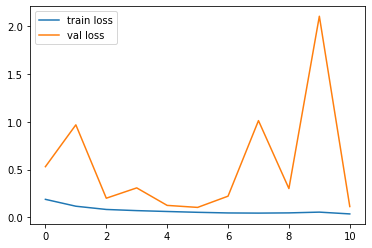

In [51]:
#loss graph
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.legend()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


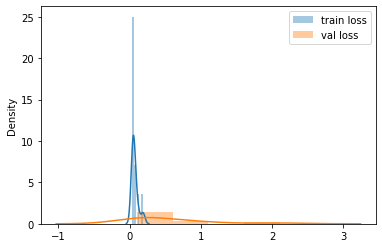

In [52]:
import seaborn as sns
sns.distplot(history.history['loss'],label='train loss')
sns.distplot(history.history['val_loss'],label='val loss')
plt.legend()

In [ ]:
plt.savefig('loss-graph.png')
plt.show()

<Figure size 432x288 with 0 Axes>

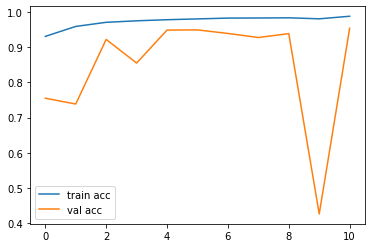

In [53]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

In [ ]:
plt.savefig('acc-graph.png')
plt.show()

<Figure size 432x288 with 0 Axes>

In [64]:
history=model.fit(data_test, epochs=10,  shuffle=True)

Epoch 1/10
128/128 [==============================] - 10s 76ms/step - loss: 0.0208 - accuracy: 0.9936
Epoch 2/10
128/128 [==============================] - 10s 76ms/step - loss: 0.0165 - accuracy: 0.9934
Epoch 3/10
128/128 [==============================] - 10s 76ms/step - loss: 0.0198 - accuracy: 0.9956
Epoch 4/10
128/128 [==============================] - 10s 76ms/step - loss: 0.0142 - accuracy: 0.9953
Epoch 5/10
128/128 [==============================] - 10s 76ms/step - loss: 0.0146 - accuracy: 0.9948
Epoch 6/10
128/128 [==============================] - 10s 75ms/step - loss: 0.0095 - accuracy: 0.9973
Epoch 7/10
128/128 [==============================] - 10s 75ms/step - loss: 0.0143 - accuracy: 0.9958
Epoch 8/10
128/128 [==============================] - 10s 76ms/step - loss: 0.0247 - accuracy: 0.9934
Epoch 9/10
128/128 [==============================] - 10s 75ms/step - loss: 0.0142 - accuracy: 0.9936
Epoch 10/10
128/128 [==============================] - 10s 76ms/step - loss: 0.007

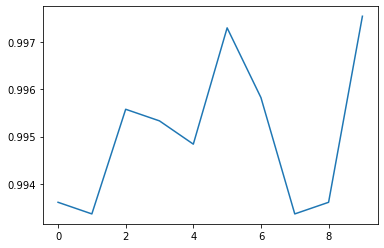

In [68]:
# accuracies
plt.plot(history.history['accuracy'], label='test acc')


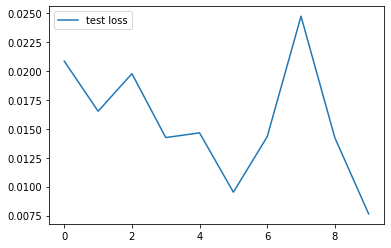

In [69]:
plt.plot(history.history['loss'], label='test loss')
plt.legend()

In [80]:
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred,axis=1)
print(classification_report(y_pred,y_test))

128/128 [==============================] - 3s 22ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.26      0.41      4070
         1.0       0.00      0.00      0.00         0

    accuracy                           0.26      4070
   macro avg       0.50      0.13      0.20      4070
weighted avg       1.00      0.26      0.41      4070



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [82]:
model.save("/content/drive/MyDrive/Data/covid19-detection.h5")